In [70]:
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


Utrekning av bæreevne, forutsetter grunnvassnivå under fundament

In [71]:
#Input
phi = 38 #Grader
attraksjon = 10 #kPa
gamma_m = 1.4
Fv = 500 #kN  Ikkje brukt i berekning av plot for fundamentbredde mot vertikalspenning, kunn som sjekk for ruhet
Fh = 50 #kN kkje brukt i berekning av plot for fundamentbredde mot vertikalspenning, kunn som sjekk for ruhet
gamma = 18 #kN/m3  
ruhet = 0.17 #
helling = 2 #Flatt - > stort tall
helling_forhold = 1/helling
print('brukt helling: ', helling_forhold)

brukt helling:  0.5


In [72]:
b0 = 3 #m
fot_dybde = 1

In [73]:
tan_phi = math.tan(math.radians(phi))
tan_ro = tan_phi/gamma_m
ro = phi/gamma_m
gamma_eff = gamma - 10
p_eff = fot_dybde * gamma #TODO grunnvatn forutsetter no grunnvatn i nivå med underkant fundament
qv = Fv/b0

In [74]:
#Regner ut ruhet, ut fra antatt laster
def rb(Fh, B0, qv, a, tan_ro):
    rb = (Fh/b0) / ((qv + attraksjon) * tan_ro)
    return rb

print(rb(Fh, b0, qv, attraksjon, tan_ro))

0.16904889481795382


In [75]:
#Berekning av Nq og Ngamma
def n_fakt(tan_ro, ruhet, helling):
    tan_alpha = tan_ro + math.sqrt(1+tan_ro**2)
    N = tan_alpha**2
    r = math.atan(tan_ro)
    Kp = (2*N)/(N+1) * math.exp((math.pi/2 + r)*tan_ro)
    x0 = 2*(1-ruhet)*tan_ro
    r_r = math.atan(tan_ro)*180/math.pi
    ap = 0.25*math.pi + 0.5*r
    f_omega = 1/(ruhet+0.0001) * (1 - (math.sqrt(1 - (ruhet**2))))
    w_rad= math.atan(f_omega * math.tan(math.pi/4 + 0.5 * r))
    w = math.degrees(w_rad)
    s = (1/helling)/tan_ro
    aa_rad = math.pi/4 - r/2
    x0_list = []
    tanpsi = []
    psi = []
    c = []
    Rot = []
    xc = []
    diff = []
    n_gamma_list = []
    for i in range(20):
        if i == 0:
            x0_list.append(x0)
        else:
            x0_list.append(xc[i-1])
        tanpsi.append(x0_list[i]-tan_ro)
        psi.append(math.atan(tanpsi[i]))
        c.append((1+tanpsi[i]*tan_ro)*Kp*math.exp(2*psi[i]*tan_ro)-1)
        Rot.append((1-ruhet)**2 + (1-ruhet)/c[i])
        xc.append((1-ruhet+math.sqrt(Rot[i]))*tan_ro)
        diff.append((x0_list[i]-xc[i])**2)
        if diff[i] < 0.000001:
            n_gamma_list.append((2*c[i]*xc[i]+tan_ro)/(1+(tanpsi[i]**2)))
        else:
            n_gamma_list.append(1000)
    Nq = ((N+1)+(N-1)*math.cos(2*w_rad)) * math.exp((math.pi - 2*w_rad)*tan_ro)/2
    N_gamma = min(n_gamma_list)
        
    return Nq, N_gamma
    
nq, ng = n_fakt(tan_ro, rb(Fh, b0, qv, attraksjon, tan_ro), helling)
print('nq: ', nq, 'ng:', ng)
    

nq:  14.070201797452675 ng: 13.58087277277435


In [76]:
#Reduksjonsfaktor for hellende terreng
if helling_forhold == 0:
    fsq = 1
    fsa = 1
elif helling_forhold > 0 and helling_forhold <= 0.31:
    fsa = 1-(1.0667*helling_forhold)
    fsq = 1-(1.633*helling_forhold)
elif helling_forhold > 0.31 and helling_forhold <= 0.41:
    fsa = 0.68-0.95*(helling_forhold-0.3)
    fsq = 0.51-1.3*(helling_forhold-0.3)
elif helling_forhold > 0.41 and helling_forhold <= 0.51:
    fsa = 0.585-0.8*(helling_forhold-0.4)
    fsq = 0.38-1.2*(helling_forhold-0.4)
elif helling_forhold > 0.51 and helling_forhold <= 0.61:
    fsa = 0.505-0.7*(helling_forhold-0.5)
    fsq = 0.26-0.8*(helling_forhold-0.5)
elif helling_forhold > 0.61 and helling_forhold <= 0.71:
    fsa = 0.435-0.65*(helling_forhold-0.6)
    fsq = 0.18-0.65*(helling_forhold-0.6)
elif helling_forhold > 0.71 and helling_forhold <= 0.75:
    fsa = 0.37-0.9*(helling_forhold-0.7)
    fsq = 0.115-0.7*(helling_forhold-0.7)
else:
    fsa = 0
    fsq = 0
    
print('fsq: ', fsq)
print('fsa: ', fsa)

#TODO kap 6.2 i HB v220 anna metode for utrekning av fsa og fsq

#fsa = math.exp**(-2 * )
    
    

fsq:  0.26
fsa:  0.505


In [77]:
Nq, Ngamma = n_fakt(tan_ro, ruhet, helling)

In [78]:
#Set fundamentbredder som skal reknes ut
fra = 1.5
til = 4
step = 0.1
#Sett fundamentdjuper som skal reknes ut (4 stk)
fundamentdjupner = [0, 0.5, 1, 1.5]

sigmalist05 = []
sigmalist1 = []
sigmalist15 = []
b0liste05 = []
b0liste1 = []
b0liste15 = []

In [79]:
#Definerer lister lagring av data fra berekninger 
sigmalist0 = [] 
sigmalist05 = [] 
sigmalist1 = [] 
sigmalist15 = []
b0liste0 = [] 
b0liste05 = [] 
b0liste1 = [] 
b0liste15 = []

In [80]:
#Beregner igjennom tilfeller med definerte fundamentdjupner og 
for b in np.arange(fra, til, step):
    b_0 = b
    sigmalist0.append(fsq * (Nq * gamma * fundamentdjupner[0]) + (0.5 * Ngamma * gamma_eff * b_0) + (Nq * fsa -1) * attraksjon)
    b0liste0.append(b_0)
    
for b in np.arange(fra, til, step):
    b_0 = b
    sigmalist05.append(fsq * (Nq * gamma * 0.5) + (0.5 * Ngamma * gamma_eff * b_0) + (Nq * fsa -1) * attraksjon)
    b0liste05.append(b_0)
    
for b in np.arange(fra, til, step):
    b_0 = b
    sigmalist1.append(fsq * (Nq * gamma * 1) + (0.5 * Ngamma * gamma_eff * b_0) + (Nq * fsa -1) * attraksjon)
    b0liste1.append(b_0)
    
for b in np.arange(fra, til, step):
    b_0 = b
    sigmalist15.append(fsq * (Nq * gamma * 1.5) + (0.5 * Ngamma * gamma_eff * b_0) + (Nq * fsa -1) * attraksjon)
    b0liste15.append(b_0)

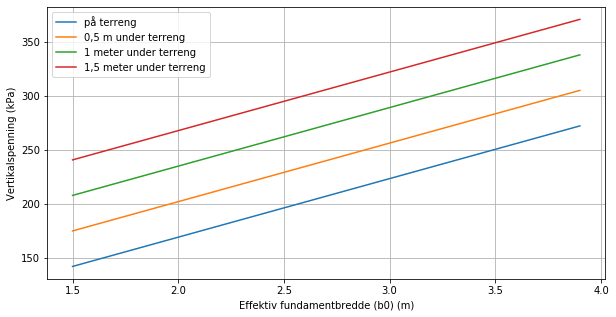

In [81]:
fix, ax = plt.subplots(figsize=(10,5))
ax.plot(b0liste, sigmalist0, label='på terreng')
ax.plot(b0liste, sigmalist05, label='0,5 m under terreng')
ax.plot(b0liste, sigmalist1, label='1 meter under terreng')
ax.plot(b0liste, sigmalist15, label='1,5 meter under terreng')
ax.grid(True)
ax.set_ylabel('Vertikalspenning (kPa)')
ax.set_xlabel('Effektiv fundamentbredde (b0) (m)')
ax.legend()